In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import random
import scipy
import scipy.io as scio
from scipy.signal import butter, sosfilt
from scipy.stats import bernoulli
from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split, RandomSampler
import numpy as np
#from torchmetrics.classification import ConfusionMatrix
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.preprocessing import normalize
import os
from os import *
import matplotlib.pyplot as plt
import seaborn as sns
#from Models.Transformer import TransformerModel
#from Models.PositionalEncoding import LearnedPositionalEncoding
import torch.optim.lr_scheduler as lr_scheduler



In [3]:
# pip install oct2py
#!apt-get install octave -y

In [4]:
if (not(os.path.isdir('./EEGPT_Models'))):
    os.makedirs('./EEGPT_Models')
# if (not(os.path.isdir('./Top_Models'))):
#     os.makedirs('./Top_Models')

In [5]:
#os.removedirs('./Top_Models')

In [6]:
# CHECK GPU RESOURCES
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

torch.manual_seed(4460)# you don't have to set random seed beyond this block
np.random.seed(4460)

GPU available: True


In [7]:
os.listdir()

['EEGPT_Models', '.virtual_documents', '__notebook_source__.ipynb']

In [8]:
datatype = 'eeg-merge'

In [9]:
if datatype == 'eeg':
    sub01 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_1.mat')
    sub02 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_2.mat')
    sub03 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_3.mat')
    sub04 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_4.mat')
    sub05 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_5.mat')
    # sub06 = scio.loadmat('/content/drive/MyDrive/Columbia Spring 2023/Signal Modeling/Project-EEG-Classifier/Signal_Processing_FC/Signal_Processing_FC/Subject_6.mat')
    sub07 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_7.mat')
    sub08 = scio.loadmat('/kaggle/input/eeg-tensors/Signal_Processing_FC/Subject_8.mat')
    data = {'sub01':sub01,'sub02':sub02,'sub03':sub03,'sub04':sub04,'sub05':sub05,'sub06':sub06,'sub07':sub07,'sub08':sub08}
#     data = {'sub01':sub01,'sub02':sub02,'sub03':sub03,'sub04':sub04,'sub05':sub05,'sub07':sub07,'sub08':sub08}
elif datatype == 'modeeg':
    sub01 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub01.mat')
    sub02 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub02.mat')
    sub03 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub03.mat')
    sub04 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub04.mat')
    sub05 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub05.mat')
    sub06 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub06.mat')
    sub07 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub07.mat')
    sub08 = scio.loadmat('/kaggle/input/mod-eeg-tensors-imputed/Modified_EEG_Tensors/sub08.mat')
    data = {'sub01':sub01,'sub02':sub02,'sub03':sub03,'sub04':sub04,'sub05':sub05,'sub06':sub06,'sub07':sub07,'sub08':sub08}
elif datatype == 'eeg-merge':
    sub01 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_1.mat')
    sub02 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_2.mat')
    sub03 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_3.mat')
    sub04 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_4.mat')
    sub05 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_5.mat')
    sub06 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_6.mat')
    sub07 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_7.mat')
    sub08 = scio.loadmat('/kaggle/input/eeg-tensors-mergeimputed/EEG_Tensors/Subject_8.mat')
    data = {'sub01':sub01,'sub02':sub02,'sub03':sub03,'sub04':sub04,'sub05':sub05,'sub06':sub06,'sub07':sub07,'sub08':sub08}
#     data = {'sub01':sub01,'sub02':sub02,'sub03':sub03,'sub04':sub04,'sub05':sub05,'sub07':sub07,'sub08':sub08}

In [10]:
class EEGData():
  def __init__(self, samples, labels):
    self.X = samples
    self.Y = labels
    self.indices = list(range(np.size(self.Y,0)))
  def __getitem__(self, index):
    eegTensor = self.X[index]
    label = self.Y[index]    
    sample = {'eeg' : eegTensor,
              'label' : label}
    return sample
    #return self.x[self.indices[index]], self.y[self.indices[index]]
  def shuffle(self):
    random.shuffle(self.indices)
  def __len__(self):
    return (np.size(self.Y,0))

In [11]:
class testEEGPT(nn.Module):
  def __init__(
      self,
      eeg_channels = 60,
      time_len = 182
               ):
    super(testEEGPT,self).__init__()
    # BUILD SPATIAL PATH
    ## CNN MODULE
    self.Conv1_s = nn.Conv1d(in_channels=eeg_channels, out_channels=eeg_channels, kernel_size=17, stride=1, padding="same")
    self.AvgPool1_s = nn.AvgPool1d(kernel_size=2,stride=2)
    self.Conv2_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=14,stride=1,padding=6) # output should be 
    self.grp_norm_s = nn.GroupNorm(eeg_channels//6,eeg_channels)
    ## TRANSFORMER MODULE
    self.PosEnc1_s = PositionalEncoder(embedding_dim=(90),max_length=1000)
    self.Transf1_s = EncoderTransformer(inSize=(90),outSize=4,numLayers=10,hiddenSize=1,numHeads=10,dropout=0.01)

    # BUILD TEMPORAL PATH
    # CNN MODULE
    self.dwconv1_t = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels, kernel_size=eeg_channels, stride=1, groups = eeg_channels, padding="same")
    self.AvgPool1_t = nn.AvgPool2d(kernel_size=(2,1))    
#     self.grp_norm_t = nn.GroupNorm(eeg_channels//6, eeg_channels)
    # TRANSFORMER MODULE
#     self.PosEnc1_t = PositionalEncoder(embedding_dim=eeg_channels//2,max_length=1500)
    self.PosEnc1_t = PositionalEncoder(embedding_dim=eeg_channels,max_length=1500)
    self.Transf1_t = EncoderTransformer(inSize=eeg_channels,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)
#     self.Transf1_t = EncoderTransformer(inSize=eeg_channels//2,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)
    # Build Fully Connected Path
    self.fc1 = nn.Linear(60+182,1)

  def forward(self, x):
    # Spatial Pass
    x_s = self.Conv1_s(x)
#     print('x_s conv1: ',x_s.shape)
    x_s = self.AvgPool1_s(x_s)
#     print('x_s avg1: ',x_s.shape)
    x_s = self.Conv2_s(x_s)
#     print('x_s conv2: ',x_s.shape)
#     x_s = self.grp_norm_s(x_s)
    x_s = self.PosEnc1_s(x_s)
    x_s = self.Transf1_s(x_s)
#     print('x_s tf1: ',x_s.shape)
    
    # Temporal Pass
#     x_t = self.dwconv1_t(x)
#     print('x_t conv1: ',x_t.shape)
#     x_t = self.AvgPool1_t(x_t)
#     x_t = self.grp_norm_t(x_t)
#     print('x_t avg1: ',x_t.shape)
    x = x.permute(0,2,1) # transpose to present time wise vectors to transformer encoder    
    x_t = self.PosEnc1_t(x)
    x_t = self.Transf1_t(x_t)
#     print('x_t tf1: ',x_t.shape)
    # Concatenation
    x_s = x_s.permute(0,2,1)
    x_t = x_t.permute(0,2,1)
    x_cat = torch.cat((x_s, x_t),dim=2)
#     print('x_cat: ',x_cat.shape)
    # Output Pass: Fully Connected into Softmax
    x = self.fc1(x_cat)
    x = torch.log_softmax(x,dim=1)
    return x

class testEEGPTFull(nn.Module):
  def __init__(
      self,
      eeg_channels = 60,
      time_len = 1200
               ):
    super(testEEGPTFull,self).__init__()
    # BUILD SPATIAL PATH
    ## CNN MODULE
    self.Conv1_s = nn.Conv1d(in_channels=eeg_channels, out_channels=eeg_channels, kernel_size=17, stride=1, padding="same")
    self.AvgPool1_s = nn.AvgPool1d(kernel_size=10,stride=10)
    self.Conv2_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=14,stride=1,padding=6) # output should be 
    self.grp_norm_s = nn.GroupNorm(eeg_channels//6,eeg_channels)
    ## TRANSFORMER MODULE
    self.PosEnc1_s = PositionalEncoder(embedding_dim=(120),max_length=1000)
    self.Transf1_s = EncoderTransformer(inSize=(120),outSize=4,numLayers=10,hiddenSize=1,numHeads=10,dropout=0.01)

    # BUILD TEMPORAL PATH
    # CNN MODULE
    self.dwconv1_t = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels, kernel_size=eeg_channels, stride=1, groups = eeg_channels, padding="same")
    self.AvgPool1_t = nn.AvgPool2d(kernel_size=(2,1))    
#     self.grp_norm_t = nn.GroupNorm(eeg_channels//6, eeg_channels)
    # TRANSFORMER MODULE
#     self.PosEnc1_t = PositionalEncoder(embedding_dim=eeg_channels//2,max_length=1500)
    self.PosEnc1_t = PositionalEncoder(embedding_dim=eeg_channels,max_length=1500)
    self.Transf1_t = EncoderTransformer(inSize=eeg_channels,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)
#     self.Transf1_t = EncoderTransformer(inSize=eeg_channels//2,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)
    # Build Fully Connected Path
    self.fc1 = nn.Linear(60+182,1)

  def forward(self, x):
    # Spatial Pass
    x_s = self.Conv1_s(x)
#     print('x_s conv1: ',x_s.shape)
    x_s = self.AvgPool1_s(x_s)
#     print('x_s avg1: ',x_s.shape)
    x_s = self.Conv2_s(x_s)
#     print('x_s conv2: ',x_s.shape)
#     x_s = self.grp_norm_s(x_s)
    x_s = self.PosEnc1_s(x_s)
    x_s = self.Transf1_s(x_s)
#     print('x_s tf1: ',x_s.shape)
    
    # Temporal Pass
#     x_t = self.dwconv1_t(x)
#     print('x_t conv1: ',x_t.shape)
#     x_t = self.AvgPool1_t(x_t)
#     x_t = self.grp_norm_t(x_t)
#     print('x_t avg1: ',x_t.shape)
    x = x.permute(0,2,1) # transpose to present time wise vectors to transformer encoder    
    x_t = self.PosEnc1_t(x)
    x_t = self.Transf1_t(x_t)
#     print('x_t tf1: ',x_t.shape)
    # Concatenation
    x_s = x_s.permute(0,2,1)
    x_t = x_t.permute(0,2,1)
    x_cat = torch.cat((x_s, x_t),dim=2)
#     print('x_cat: ',x_cat.shape)
    # Output Pass: Fully Connected into Softmax
    x = self.fc1(x_cat)
    x = torch.log_softmax(x,dim=1)
    return x

class EEGPT_A(nn.Module):
  def __init__(
      self,
      eeg_channels = 60,
      time_len = 1200
               ):
    super(EEGPT_A,self).__init__()
    # BUILD SPATIAL PATH
    ## CNN MODULE
    self.Conv1_s = nn.Conv1d(in_channels=eeg_channels, out_channels=eeg_channels, kernel_size=17, stride=1, padding="same")
    self.AvgPool1_s = nn.AvgPool1d(kernel_size=10,stride=10)
    self.Conv2_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=15,stride=1,padding="same") # output should be 
    self.grp_norm_s = nn.GroupNorm(eeg_channels//6,eeg_channels)
    ## TRANSFORMER MODULE
    self.PosEnc1_s = PositionalEncoder(embedding_dim=time_len//10,max_length=1000)
    self.Transf1_s = EncoderTransformer(inSize=time_len//10,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)

    # BUILD TEMPORAL PATH
    # CNN MODULE
    self.dwconv1_t = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels, kernel_size=eeg_channels, stride=1, groups = eeg_channels, bias=False, padding="same")
    self.AvgPool1_t = nn.AvgPool2d(kernel_size=(2,1))    
    # TRANSFORMER MODULE
    self.PosEnc1_t = PositionalEncoder(embedding_dim=eeg_channels//2,max_length=1500)
#     self.Transf1_t = EncoderTransformer(inSize=time_len,outSize=4,numLayers=3,hiddenSize=1,numHeads=6,dropout=0.01)
    self.Transf1_t = EncoderTransformer(inSize=eeg_channels//2,outSize=4,numLayers=10,hiddenSize=1,numHeads=6,dropout=0.01)
    # Build Fully Connected Path
    self.fc1 = nn.Linear(1260,1)

  def forward(self, x):
    # Spatial Pass
    x_s = self.Conv1_s(x)
#     print('x_s conv1: ',x_s.shape)
    x_s = self.AvgPool1_s(x_s)
#     print('x_s avg1: ',x_s.shape)
    x_s = self.Conv2_s(x_s)
#     print('x_s conv21: ',x_s.shape)
    x_s = self.grp_norm_s(x_s)
    x_s = self.PosEnc1_s(x_s)
    x_s = self.Transf1_s(x_s)
#     print('x_s tf1: ',x_s.shape)
    
    # Temporal Pass
    x_t = self.dwconv1_t(x)
#     print('x_t conv1: ',x_t.shape)
    x_t = self.AvgPool1_t(x_t)
#     print('x_t avg1: ',x_t.shape)
    x_t = x_t.permute(0,2,1) # transpose to present time wise vectors to transformer encoder    
    x_t = self.PosEnc1_t(x_t)
    x_t = self.Transf1_t(x_t)
#     print('x_t tf1: ',x_t.shape)
    # Concatenation
    x_s = x_s.permute(0,2,1)
    x_t = x_t.permute(0,2,1)
    x_cat = torch.cat((x_s, x_t),dim=2)
#     print('x_cat: ',x_cat.shape)
    # Output Pass: Fully Connected into Softmax
    x = self.fc1(x_cat)
    x = torch.log_softmax(x,dim=1)
    return x


# class EEGPT(nn.Module):
#   def __init__(
#       self,
#       eeg_channels = 60,
#       time_len = 1200
#                ):
#     super(EEGPT,self).__init__()
#     # BUILD SPATIAL PATH
#     ## CNN MODULE
#     self.Conv1_s = nn.Conv1d(in_channels=eeg_channels, out_channels=eeg_channels, kernel_size=16, stride=1, padding="same")
#     self.AvgPool1_s = nn.AvgPool1d(kernel_size=4,stride=4)
#     self.Conv2_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=10,stride=1,padding="same")
#     self.AvgPool2_s = nn.AvgPool1d(kernel_size=3,stride=3)
#     self.Conv3_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=9,stride=1,padding="same")
#     self.AvgPool3_s = nn.AvgPool1d(kernel_size=3,stride=3)
#     self.Conv4_s = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels,kernel_size=9,stride=1,padding="valid")
#     ## TRANSFORMER MODULE
#     self.PosEnc1_s = PositionalEncoder(embedding_dim=100,max_length=1000)
#     self.Transf1_s = EncoderTransformer(inSize=100,outSize=5,numLayers=10,hiddenSize=10,numHeads=10,dropout=0.001)

#     # BUILD TEMPORAL PATH
#     # CNN MODULE
#     self.dwconv1_t = nn.Conv1d(in_channels=eeg_channels,out_channels=eeg_channels, kernel_size=eeg_channels, stride=1, groups = eeg_channels, bias=True, padding="same")
#     self.AvgPool1_t = nn.AvgPool2d(kernel_size=(2,1)) 
#     self.conv2_t = nn.Conv1d(in_channels=eeg_channels//2,out_channels=eeg_channels//2, kernel_size=3, stride=1, bias = False, padding='same')
#     self.AvgPool2_t = nn.AvgPool2d(kernel_size=(2,1)) 
#     # TRANSFORMER MODULE
#     self.PosEnc1_t = PositionalEncoder(embedding_dim=60,max_length=1500)
#     self.Transf1_t = EncoderTransformer(inSize=60,outSize=5,numLayers=5,hiddenSize=5,numHeads=10,dropout=0.001)
#     # Build Fully Connected Path
#     if datatype == 'eeg':
#         self.fc1 = nn.Linear(1260,1)
#     elif datatype == 'ica':
#         self.fc1 = nn.Linear(1220,1)
        

#   def forward(self, x):
#     # Spatial Pass
    
#     x = x.to(torch.float32)
# #     print('x: ',x.shape)
#     x_s = self.Conv1_s(x)
# #     print('x conv1: ',x_s.shape)
#     x_s = self.AvgPool1_s(x_s)
# #     print('x avg1: ',x_s.shape)
#     x_s = self.Conv2_s(x_s)
# #     print('x conv2: ',x_s.shape)
# #     x_s = self.AvgPool2_s(x_s)
# #     print('x avg2: ',x_s.shape)
# #     x_s = self.Conv3_s(x_s)
# #     print('x conv3: ',x_s.shape)
# #     x_s = self.AvgPool3_s(x_s)
# #     x_s = self.Conv4_s(x_s)
#     x_s = self.PosEnc1_s(x_s)
#     x_s = self.Transf1_s(x_s)
# #     print('x_s_transf: ', x_s.shape)
    
#     # Temporal Pass
#     #x_t = self.dwconv1_t(x)
#     #print('x_t conv1: ',x_t.shape)
#     #x_t = self.AvgPool1_t(x_t)
# #     print('x_t avg1: ',x_t.shape)
#     #x_t = self.conv2_t(x_t)
# #     print('x_t conv2: ',x_t.shape)
#     #x_t = self.AvgPool2_t(x_t)
# #     print('x_t avg2: ',x_t.shape)
#     x_t = x.permute(0,2,1) # transpose to present time wise vectors to transformer encoder
# #     print('x_t avg1_permute: ',x_t.shape)    
#     x_t = self.PosEnc1_t(x_t)
#     x_t = self.Transf1_t(x_t)
# #     print('x_t_transf: ', x_t.shape)
    
#     # Concatenation
#     x_s = x_s.permute(0,2,1)
#     x_t = x_t.permute(0,2,1)
# #     print('x_t transf1_perm: ',x_t.shape)
# #     print('x_s transf1_perm: ',x_s.shape)
#     x_cat = torch.cat((x_s, x_t),dim=2)
#     # Output Pass: Fully Connected into Softmax
# #     print('x cat: ',x_cat.shape)
#     x = self.fc1(x_cat)
# #     print('x fc1: ',x.shape)
#     x = torch.log_softmax(x,dim=1)
# #     print('x softmax: ',x.shape)
#     return x

class EncoderTransformer(nn.Module):
  def __init__(self, inSize, outSize, numLayers=3, hiddenSize=1, numHeads=8, dropout=0.01):
    super(EncoderTransformer,self).__init__()
    self.encoderLayer = nn.TransformerEncoderLayer(d_model=inSize, nhead=numHeads, dim_feedforward=hiddenSize, dropout=dropout)
    self.encoder = nn.TransformerEncoder(self.encoderLayer,num_layers=numLayers)
    self.fc1 = nn.Linear(inSize, outSize)
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x

## CHECK HERE !
class PositionalEncoder(nn.Module):
  def __init__(self, embedding_dim, max_length=1000):
    super(PositionalEncoder,self).__init__()
    pe = torch.zeros(max_length, embedding_dim)
    position = torch.arange(0, max_length,dtype=float).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, embedding_dim, 2).float()
        * (-torch.log(torch.tensor(10000.0))/embedding_dim)
    )
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe',pe)

  def forward(self, x):
    #print(self.pe[:x.size(1)].shape)
    return x + self.pe[:x.size(1),:]



In [12]:
# PREPROCESSING FUNCTIONS
#tensor = subx
#print(np.shape(subx))
class AddGaussNoise(object):
    def __init__(self, std, mean, p):
        self.std = std
        self.mean = mean
        self.prob = p # tune probability controlling fraction of dataset this augmentation will be applied to
    def __call__(self, tensor):
        #return img + torch.randn_like(img)*std + mean
        bern_rv = bernoulli.rvs(self.prob)
        if bern_rv == 1:
            ret_tensor = tensor + np.random.randn(np.shape(tensor)[0],np.shape(tensor)[1])*self.std + self.mean
        else:
            ret_tensor = tensor                
        return ret_tensor 

def mas2565_normalize(tensor):
    # normalizes a 60 x 1200 tensor, time wise
    normal_tensor = normalize(tensor,axis=1,norm='l2')
    return normal_tensor
def mas2565_filter(tensor):
    Fs = 1000
    lowcut = 0.5
    highcut = 40
    order = 4
    nyq = 0.5*Fs
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band',output='sos')
    filtered_tensor = sosfilt(sos, tensor, axis=1)
    return filtered_tensor
#print(np.shape(mas2565_normalize(tensor)))

def mas2565_ICA(tensor):
    pass
    #return ICA_tensor

In [13]:
#print(data['sub01']['X_EEG_TRAIN'])

In [14]:
# COMPOSE MEGA DATASET FROM ALL SUBJECT TENSORS
numSets = 8
X = []
Y = []
ID = []
for i in range(numSets):
    if i != 5:
        subSetX = data[('sub0'+str(i+1))]['X_EEG_TRAIN']
        subSetY = data[('sub0'+str(i+1))]['Y_EEG_TRAIN']
  #print(np.size(subSetY,0))
    for j in range(np.size(subSetY,0)):   
        #print(np.shape(subSetX)[])
        subx = subSetX[:,:,j]

        #subx = mas2565_ICA(subx)
        subx = mas2565_filter(subx)
        subx = mas2565_normalize(subx)
        

        #noise = AddGaussNoise(50,0,0.7) # noise augmentation
        #subx = noise(subx)
        subx = torch.Tensor(subx)
        #subx = mas2565_filter(subx)
        #print(np.shape(subx))
        suby = subSetY[j,:]
        # miniSet = EEGData(subx,suby)
        # print(np.shape(miniSet.y))
        X.append(subx)
        Y.append(suby)


        # DEBUGGING PRINTS
        #print(np.size(subSetY,0))
        #print(np.shape(subSetX))
        #print(np.shape(subSetY))
        #print(miniSet.__len__())

#MegaSet = ConcatDataset(megaSet)
#print(np.shape((MegaSet).x))
#MegaSet = RandomSampler(MegaSet)
#print(np.shape(X))
#print(np.shape(Y[1]))

myEEG = EEGData(X,Y)

# Load Dataset using EEGData and Dataloader
trainset, validset, testset = random_split(myEEG,[0.70, 0.15, 0.15])
trainloader = DataLoader(trainset,batch_size=10,shuffle=True)
validloader = DataLoader(validset,batch_size=10,shuffle=True)
testloader = DataLoader(testset, batch_size =1, shuffle=True)

In [15]:
# Build/Instantiate Model
eegpt = EEGPT_A(eeg_channels=60, time_len=1200)
if cuda:
  eegpt.cuda()

# Call Optimizer
adam = Adam(eegpt.parameters(),lr=0.00005)

In [16]:
# COUNT MODEL PARAMETERS
param_count = 0;
for param in eegpt.parameters():
    param_count += param.numel()

print('number of model params: ', param_count)

number of model params:  812281


In [17]:
# MODEL TRAINING
scheduler = lr_scheduler.CosineAnnealingLR(adam, T_max=100, eta_min=0.000001)
EPOCHS = 100
train_epoch_loss = list()
validation_epoch_loss = list()
for epoch in range(EPOCHS):
  train_loss = list()
  valid_loss = list()
  eegpt.train() # put model in train mode  
  for i, sample in enumerate(trainloader):
    eegTensor = sample['eeg']
    #print(np.shape(eegTensor))
    label = sample['label']
    #print('label shape: ',np.shape(label))
    #print('sample: ', sample)
    if cuda:
      train_pred = eegpt(eegTensor.cuda())
      # print('pred shape: ', train_pred.shape)
      # calculate loss
      loss_fun = nn.CrossEntropyLoss()
      loss = loss_fun(train_pred, label.cuda().long())
      train_loss.append(loss.cpu().data.item())
      
      # reset gradient
      adam.zero_grad()
      # back propagation
      loss.backward()
      # Update parameters
      adam.step()
      scheduler.step()
      #print('epoch: ', epoch, ' loss: ', loss.item())
      
      #print(f'EPOCH {epoch + 1}/{EPOCHS} - Training Batch {i+1}/{len(trainloader)} - Loss: {loss.item()}', end='\r')
  eegpt.eval()
  for i, samples in enumerate(validloader):
    eegTensor = sample['eeg']
    #print(np.shape(eegTensor))
    label = sample['label']
    #print(np.shape(label))
    #print('sample: ', sample)
    if cuda:
      valid_pred = eegpt(eegTensor.cuda())
      # calculate loss
      loss_fun = nn.CrossEntropyLoss()
      loss = loss_fun(train_pred, label.cuda().long())
      valid_loss.append(loss.cpu().data.item())
      
  train_epoch_loss.append(np.mean(train_loss))
  validation_epoch_loss.append(np.mean(valid_loss))
  print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))
  # print("Epoch: {} | train_loss: {}".format(epoch, train_epoch_loss[-1]))
  torch.save(eegpt.state_dict(), '/kaggle/working/EEGPT_Models/checkpoint_epoch_%s.pth' % (epoch))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:895.)
  self.padding, self.dilation, self.groups)


Epoch: 0 | train_loss: 1.2928046971559524 | validation_loss: 0.9919990234904819
Epoch: 1 | train_loss: 0.939210706949234 | validation_loss: 0.8359488248825073
Epoch: 2 | train_loss: 0.8372474178671837 | validation_loss: 0.8308035135269165
Epoch: 3 | train_loss: 0.7895573660731315 | validation_loss: 0.7278250455856323
Epoch: 4 | train_loss: 0.7267705753445626 | validation_loss: 0.6942209071583219
Epoch: 5 | train_loss: 0.7141534939408303 | validation_loss: 0.7885907159911262
Epoch: 6 | train_loss: 0.7066271096467972 | validation_loss: 0.705397261513604
Epoch: 7 | train_loss: 0.6988340795040131 | validation_loss: 0.7235288818677267
Epoch: 8 | train_loss: 0.7030360013246536 | validation_loss: 0.6957742704285516
Epoch: 9 | train_loss: 0.7042150393128395 | validation_loss: 0.7052695353825887
Epoch: 10 | train_loss: 0.7030792891979217 | validation_loss: 0.7422261370552911
Epoch: 11 | train_loss: 0.6993955492973327 | validation_loss: 0.6732427411609225
Epoch: 12 | train_loss: 0.69590406566858

best epoch:  70
(85,)
(85, 1)
accuracy:  0.5357142857142857


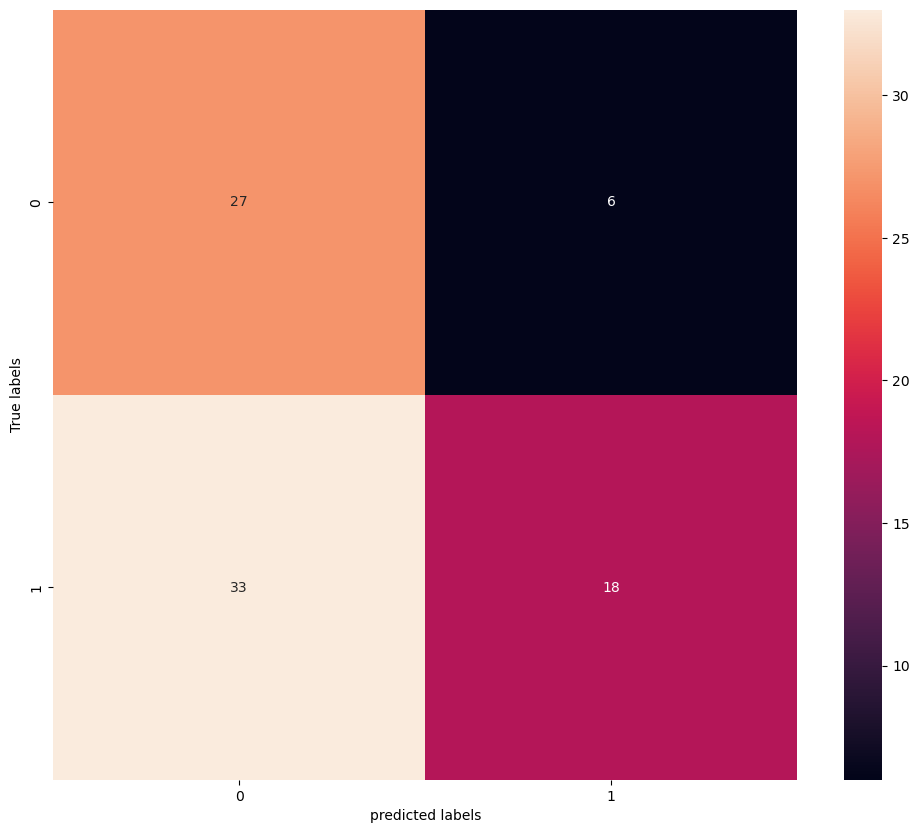

In [291]:
# BEST EPOCH
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

# LOAD BEST MODEL
# state_dict = torch.load('/kaggle/working/EEGPT_Models/checkpoint_epoch_%s.pth' % (best_epoch))
state_dict = torch.load('/kaggle/working/EEGPT_Models/checkpoint_epoch_21.pth')
# print(state_dict.keys())
eegpt.load_state_dict(state_dict)

# REPORT ACCURACY
test_preds = []
labels = []
for i, sample in enumerate(testloader):
    accuracy = list()
    eegTensor = sample['eeg']
    #print(np.shape(eegTensor))
    label = sample['label']
    labels.append(label.detach().cpu().numpy())
    #print(np.shape(labels))
    #print(np.shape(label))
    #print('sample: ', sample)
    
    #print(test_label)
    eegpt.eval()
    if cuda:
        #print(eegTensor.shape)
        test_pred = eegpt(eegTensor.cuda())
        #print(test_pred.shape)
        test_preds.append(test_pred.detach().cpu().numpy())
        # tpred = test_pred.detach().numpy()
        # tlabels = test_label.detach().numpy()
        # tpredictions = get_predicted_labels(tpred)
        #print(tpred)x
        #accuracy.append(acc)
    else:
        pass
    #print(np.mean(accuracy))
    #Acc = np.mean(accuracy)

# print('EEGPT accuracy: ',accuracy_score(tlabels,tpredictions)) # BUILD ACCURACY SCORE FUN
# CONFUSION MATRIX
pred_labels = list()
for i in range(np.shape(test_preds)[0]):
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(j)
        class_pred = np.argmax(test_preds[i][j])
        #print(class_pred)
        pred_labels.append(class_pred) 
print(np.shape(pred_labels))

true_labels = list()
for i in range(np.shape(labels)[0]):
    # print(i)
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(labels[j][0])
        #print(class_pred)
        true_labels.append(labels[i][j]) 
print(np.shape(true_labels))

brk = len(true_labels)
CM = confusion_matrix(true_labels[1:brk], pred_labels[1:brk])
accuracy = accuracy_score(true_labels[1:brk], pred_labels[1:brk])
plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');
print('accuracy: ',accuracy)

# REPORT ACCURACY
test_preds = []
labels = []
for i, sample in enumerate(testloader):
    accuracy = list()
    eegTensor = sample['eeg']
    #print(np.shape(eegTensor))
    label = sample['label']
    labels.append(label.detach().cpu().numpy())
    #print(np.shape(labels))
    #print(np.shape(label))
    #print('sample: ', sample)
    
    #print(test_label)
    eegpt.eval()
    if cuda:
        #print(eegTensor.shape)
        test_pred = eegpt(eegTensor.cuda())
        #print(test_pred.shape)
        test_preds.append(test_pred.detach().cpu().numpy())
        # tpred = test_pred.detach().numpy()
        # tlabels = test_label.detach().numpy()
        # tpredictions = get_predicted_labels(tpred)
        #print(tpred)x
        #accuracy.append(acc)
    else:
        pass
    #print(np.mean(accuracy))
    #Acc = np.mean(accuracy)

# print('EEGPT accuracy: ',accuracy_score(tlabels,tpredictions)) # BUILD ACCURACY SCORE FUN
# CONFUSION MATRIX
pred_labels = list()
for i in range(np.shape(test_preds)[0]):
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(j)
        class_pred = np.argmax(test_preds[i][j])
        #print(class_pred)
        pred_labels.append(class_pred) 
print(np.shape(pred_labels))

true_labels = list()
for i in range(np.shape(labels)[0]):
    # print(i)
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(labels[j][0])
        #print(class_pred)
        true_labels.append(labels[i][j]) 
print(np.shape(true_labels))

brk = len(true_labels)
CM = confusion_matrix(true_labels[1:brk], pred_labels[1:brk])
accuracy = accuracy_score(true_labels[1:brk], pred_labels[1:brk])
plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');
print('accuracy: ',accuracy)

print(np.shape(labels[0]))
# print(np.shape(test_preds[1]))
print(np.shape(test_preds[0]))
# st_shap = np.shape(test_preds)
print(np.exp(test_preds[1][0]))
#print(labels[2][5])

In [242]:
pred_labels = list()
for i in range(np.shape(test_preds)[0]):
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(j)
        class_pred = np.argmax(test_preds[i][j])
        #print(class_pred)
        pred_labels.append(class_pred) 
print(np.shape(pred_labels))

(85,)


In [243]:
true_labels = list()
for i in range(np.shape(labels)[0]):
    # print(i)
    for j in range(np.shape(test_preds[i])[0]):
        # print(np.exp(test_preds[i][1]))
        #print(labels[j][0])
        #print(class_pred)
        true_labels.append(labels[i][j]) 
print(np.shape(true_labels))

(85, 1)


accuracy:  0.7619047619047619


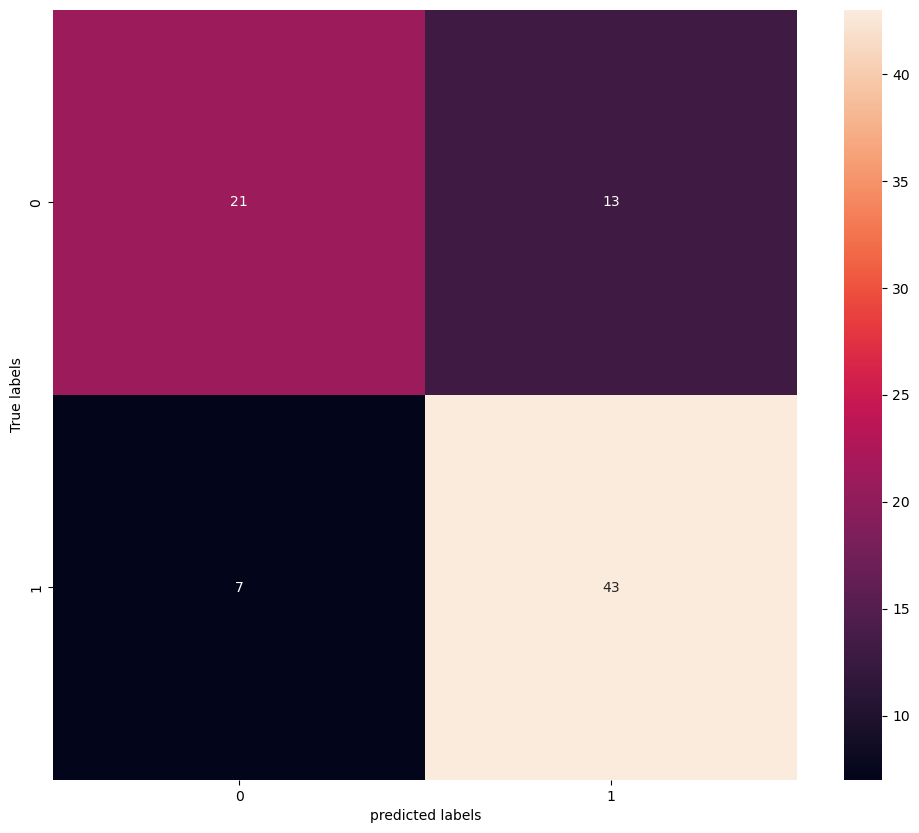

In [244]:
brk = len(true_labels)
CM = confusion_matrix(true_labels[1:brk], pred_labels[1:brk])
accuracy = accuracy_score(true_labels[1:brk], pred_labels[1:brk])
plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');
print('accuracy: ',accuracy)

In [196]:
#@title TABS REFERENCE

class up_conv_3D(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv_3D, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv3d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(8, ch_out),
            # nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.up(x)
        return x


class conv_block_3D(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block_3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(8, ch_out),
            nn.ReLU(inplace = True),
            nn.Conv3d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(8, ch_out),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class resconv_block_3D(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(resconv_block_3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(8, ch_out),
            nn.ReLU(inplace = True),
            nn.Conv3d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.GroupNorm(8, ch_out),
            nn.ReLU(inplace = True)
        )
        self.Conv_1x1 = nn.Conv3d(ch_in, ch_out, kernel_size = 1, stride = 1, padding = 0)

    def forward(self,x):

        residual = self.Conv_1x1(x)
        x = self.conv(x)
        return residual + x

# Can add squeeze excitation layers if you want to try that as well.
class ChannelSELayer3D(nn.Module):
    """
    3D extension of Squeeze-and-Excitation (SE) block described in:
        *Hu et al., Squeeze-and-Excitation Networks, arXiv:1709.01507*
        *Zhu et al., AnatomyNet, arXiv:arXiv:1808.05238*
    """

    def __init__(self, num_channels, reduction_ratio=8):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSELayer3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, D, H, W)
        :return: output tensor
        """
        batch_size, num_channels, D, H, W = input_tensor.size()
        # Average along each channel
        squeeze_tensor = self.avg_pool(input_tensor)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor.view(batch_size, num_channels)))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        output_tensor = torch.mul(input_tensor, fc_out_2.view(batch_size, num_channels, 1, 1, 1))

        return output_tensor

class TABS(nn.Module):
    def __init__(
        self,
        img_dim = 192,
        patch_dim = 8,
        img_ch = 1,
        output_ch = 3,
        embedding_dim = 512,
        num_heads = 8,
        num_layers = 4,
        hidden_dim = 1728,
        dropout_rate = 0.1,
        attn_dropout_rate = 0.1,
        ):
        super(TABS,self).__init__()

        self.Maxpool = nn.MaxPool3d(kernel_size=2,stride=2)

        self.Conv1 = resconv_block_3D(ch_in=img_ch,ch_out=8)

        self.Conv2 = resconv_block_3D(ch_in=8,ch_out=16)

        self.Conv3 = resconv_block_3D(ch_in=16,ch_out=32)

        self.Conv4 = resconv_block_3D(ch_in=32,ch_out=64)

        self.Conv5 = resconv_block_3D(ch_in=64,ch_out=128)

        self.Up5 = up_conv_3D(ch_in=128,ch_out=64)
        self.Up_conv5 = resconv_block_3D(ch_in=128, ch_out=64)

        self.Up4 = up_conv_3D(ch_in=64,ch_out=32)
        self.Up_conv4 = resconv_block_3D(ch_in=64, ch_out=32)

        self.Up3 = up_conv_3D(ch_in=32,ch_out=16)
        self.Up_conv3 = resconv_block_3D(ch_in=32, ch_out=16)

        self.Up2 = up_conv_3D(ch_in=16,ch_out=8)
        self.Up_conv2 = resconv_block_3D(ch_in=16, ch_out=8)

        self.Conv_1x1 = nn.Conv3d(8,output_ch,kernel_size=1,stride=1,padding=0)
        self.gn = nn.GroupNorm(8, 128)
        self.relu = nn.ReLU(inplace=True)

        self.num_patches = int((img_dim // patch_dim) ** 3)
        self.seq_length = self.num_patches
        self.flatten_dim = 128 * img_ch

        self.position_encoding = LearnedPositionalEncoding(
            self.seq_length, embedding_dim, self.seq_length
        )

        self.act = nn.Softmax(dim=1)

        self.reshaped_conv = conv_block_3D(512, 128)

        self.transformer = TransformerModel(
            embedding_dim,
            num_layers,
            num_heads,
            hidden_dim,

            dropout_rate,
            attn_dropout_rate,
        )

        self.conv_x = nn.Conv3d(
            128,
            embedding_dim,
            kernel_size=3,
            stride=1,
            padding=1
            )

        self.pre_head_ln = nn.LayerNorm(embedding_dim)

        self.img_dim = 192
        self.patch_dim = 8
        self.img_ch = 1
        self.output_ch = 3
        self.embedding_dim = 512

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x = self.Conv5(x5)

        x = self.gn(x)
        x = self.relu(x)
        x = self.conv_x(x)

        x = x.permute(0, 2, 3, 4, 1).contiguous()
        x = x.view(x.size(0), -1, self.embedding_dim)

        x = self.position_encoding(x)

        x, intmd_x = self.transformer(x)
        x = self.pre_head_ln(x)

        encoder_outputs = {}
        all_keys = []
        for i in [1, 2, 3, 4]:
            val = str(2 * i - 1)
            _key = 'Z' + str(i)
            all_keys.append(_key)
            encoder_outputs[_key] = intmd_x[val]
        all_keys.reverse()

        x = encoder_outputs[all_keys[0]]
        x = self._reshape_output(x)
        x = self.reshaped_conv(x)

        d5 = self.Up5(x)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        d1 = self.act(d1)

        return d1

    def _reshape_output(self, x):
        x = x.view(
            x.size(0),
            int(self.img_dim//2 / self.patch_dim),
            int(self.img_dim//2 / self.patch_dim),
            int(self.img_dim//2 / self.patch_dim),
            self.embedding_dim,
        )
        x = x.permute(0, 4, 1, 2, 3).contiguous()

        return x


def loadEEGData(data, subj):
    X = []
    Y = []
    ID = []
    print(subj)
    subjXTEST = data[subj]['X_EEG_TEST']
    for j in range(np.size(subjXTEST,2)):
        #print(j)
        subjXtest = subjXTEST[:,:,j]
        subjXtest = mas2565_filter(subjXtest)
        subjXtest = mas2565_normalize(subjXtest)  
#         print(np.shape(subjXtest))
        X.append(subjXtest)
        Y.append(j+1)
    print('eeg_tensor: ', np.shape(X))
    print('trial_num: ',Y)
    myfinalEEG = EEGData(X,Y)
    print('data loaded for: ',subj)
    return myfinalEEG

def mas2565_bagPreds(all_test_preds):
#     for i in range(np.shape(all_test_preds)[1]):
    pass
        

# BAGGING AND FINAL TESTING

# LOAD MODEL PATHS INTO A LIST
#os.listdir('/kaggle/input/top-models/Top_models/*.pth')
top_model_dir = '/kaggle/input/top-models-full/Top_models_Full/'
pth_files = [f for f in os.listdir(top_model_dir) if f.endswith('.pth')]
top_models = []
for pth in pth_files:
    pthDir = (top_model_dir + pth)
#     print(pthDir)
    top_models.append(pthDir)
print('TOP MODELS: \n')
print(top_models)

all_test_preds = []
for model in top_models:
    mod_preds = []
    state_dict = torch.load(model)
#     print(state_dict.keys())
    eegpt.load_state_dict(state_dict)
    eegpt.eval()
    for subject in data:
        subjEEGData = loadEEGData(data,subject)        
#         finalTestLoader = DataLoader(subjEEGData, batch_size =1, shuffle=False)
        testLoader = DataLoader(subjEEGData, batch_size =1, shuffle=False)
        subjTrialPreds = []
        for i, sample in enumerate(finalTestLoader):
            eeg_tensor = sample['eeg']
            trial_num = sample['label']
            finalPred = eegpt(eeg_tensor.cuda())
            subjTrialPreds.append(finalPred)        
#             print(np.shape(eeg_tensor))
#             print(trial_num)
        mod_preds.append(subjTrialPreds)
    all_test_preds.append(mod_preds)
            
            

In [ ]:
for subject in data:
        subjEEGData = loadEEGData(data,subject)